University of Zagreb  
Faculty of Electrical Engineering and Computing 
  
## Machine Learning 1 2023/2024  
http://www.fer.unizg.hr/predmet/maclea1

------------------------------

### Third lab assignment: Support Vector Machine and Non-parametric Methods

*Version: 1.0 

(c) 2015-2023 Jan Šnajder, Domagoj Alagić  

Deadline: **10 December 2023, 23:59**  

------------------------------

### Submission rules
By submitting the exercise, you confirm the following points:
1. You did not receive help from another when solving the exercise;
2. You attributed parts of the code that were taken from the Internet by referencing them in comments;
3. You did not use parts of the code from the Internet that are specific to the laboratory exercise;
4. You have not used UI-assistants for coding such as GitHub Copilot (including generative UI tools such as ChatGPT).

**Violation of any of the above rules is considered a misdemeanor and results in academic sanctions.**

### Instructions

Third lab assignment consists of eight tasks. Follow the instructions in the text cells below. Solving the lab assignment boils down to **supplementing this notebook**: inserting one or more cells **below** the text of the task, writing the appropriate code, and executing the cells.

Make sure you fully understand the code you've written. When submitting the assignment, you must be able to modify and re-execute your code at the request of the teaching assistant. Furthermore, you need to understand the theoretical basis of what you are doing, within the framework of what we covered in the lecture. Below some tasks you can also find questions that serve as guidelines for a better understanding of the material (**do not write** the answers to the questions in the notebook). Therefore, do not limit yourself only to solving the tasks, but feel free to experiment. This is precisely the purpose of these assignments.

You should do the assignment **independently**. You can consult others on the principle way of solving it, but ultimately you have to do the assignment yourself. Otherwise, the assignment makes no sense.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_2d_svc_problem(X, y, svc=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if SVC object is given, 
    the decision surfaces (with margin as well).
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if svc!=None : 
        # Create a mesh to plot in
        r = 0.03  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        Z = np.array([svc_predict(svc, x) for x in XX])
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.Paired, marker='o', s=50)

def svc_predict(svc, x) : 
    h = svc.decision_function([x])
    if np.isclose(h, 0, atol=0.03):
        return 5
    elif (h >= -1 and h < -0.03) or (h > 0.03 and h <= 1):
        return 0.5
    else: 
        return max(-1, min(1, h))
    
def plot_error_surface(err, c_range=(0,5), g_range=(0,5)):
    c1, c2 = c_range[0], c_range[1]
    g1, g2 = g_range[0], g_range[1]
    plt.xticks(range(0,g2-g1+1,5),range(g1,g2+1,5)); plt.xlabel("gamma")
    plt.yticks(range(0,c2-c1+1,5),range(c1,c2+1,5)); plt.ylabel("C")
    p = plt.contour(err);
    plt.imshow(1-err, interpolation='bilinear', origin='lower',cmap=plt.cm.gray)
    plt.clabel(p, inline=1, fontsize=10)

def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.03  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);
    
def knn_eval(n_instances=100, n_features=2, n_classes=2, n_informative=2, 
             test_size=0.3, k_range=(1, 20), n_trials=40):
    
    train_errors = []
    test_errors = []
    ks = list(range(k_range[0], k_range[1] + 1))

    for i in range(0, n_trials):
        X, y = make_classification(n_instances, n_features, n_classes=n_classes, 
                                   n_informative=n_informative, n_redundant=0, n_clusters_per_class=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        train = []
        test = []
        for k in ks:
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            train.append(1 - knn.score(X_train, y_train))
            test.append(1 - knn.score(X_test, y_test))
        train_errors.append(train)
        test_errors.append(test)
        
    train_errors = np.mean(np.array(train_errors), axis=0)
    test_errors = np.mean(np.array(test_errors), axis=0)
    best_k = ks[np.argmin(test_errors)]
    
    return ks, best_k, train_errors, test_errors

### 1. Support Vector Machine classifier (SVM)

#### (a)

Familiarize yourself with the class [`svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), which implements an interface to the implementation of [`libsvm`](http ://www.csie.ntu.edu.tw/~cjlin/libsvm/). Train the `SVC` model with a linear kernel function (i.e., without mapping of examples to feature space) on the data set `seven` (given below) with $N=7$ examples. Print the coefficients $w_0$ and $\mathbf{w}$. Print the dual coefficients and support vectors. Finally, using the `plot_2d_svc_problem` function, plot the data, decision boundary and margin. The function accepts data, labels and a classifier (an object of class `SVC`) as arguments.

In [3]:
from sklearn.svm import SVC

seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, -1, -1, -1])

w0: [3.99951172]
w: [[-9.99707031e-01 -2.92968750e-04]]
alpha: [[-4.99707031e-01 -1.46484375e-04  4.99853516e-01]]
support vectors:
[[5. 2.]
 [5. 4.]
 [3. 2.]]


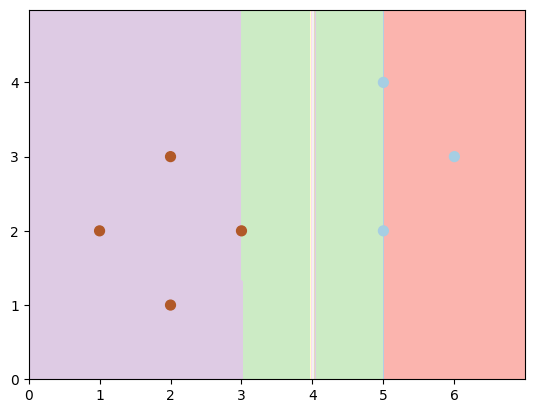

In [4]:
# Your code here...
svm_linear_seven = SVC(C=0.5, kernel='linear').fit(seven_X, seven_y)
print("w0:", svm_linear_seven.intercept_)
print("w:", svm_linear_seven.coef_)
print("alpha:", svm_linear_seven.dual_coef_)
print("support vectors:")
print(svm_linear_seven.support_vectors_)
plot_2d_svc_problem(seven_X, seven_y, svm_linear_seven)

**Q:** Which examples correspond to support vectors and why?

#### (b)

Define a `hinge(model, x, y)` function that calculates the hinge loss of the SVM model on `x` instance. Calculate the losses of the model trained on set `seven` for the examples $\mathbf{x}^{(2)}=(3,2)$ and $\mathbf{x}^{(1)}=(3.5,2)$ which are labeled as positive ($y=1$) and for $\mathbf{x}^{(3)}=(4,2)$ which is labeled as negative ($y=-1$). Also, calculate the average loss of the SVM on the set `seven`. Make sure the result is identical to what you would get using the built-in function [`metrics.hinge_loss`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.hinge_loss.html).

In [5]:
from sklearn.metrics import hinge_loss

# Your code here...
def hinge(model, x, y):
    return max(0, 1 - y * model.decision_function(x))

x1, y1 = np.array([[3, 2]]), 1
x2, y2 = np.array([[3.5, 2]]), 1
x3, y3 = np.array([[4, 2]]), -1
print("L({},  h({}))     = {}".format(y1, x1[0], hinge(svm_linear_seven, x1, y1)))
print("L({},  h({})) = {}".format(y2, x2[0], hinge(svm_linear_seven, x2, y2)))
print("L({}, h({}))     = {}".format(y3, x3[0], hinge(svm_linear_seven, x3, y3)))

average_loss = 0
for instance, label in zip(seven_X, seven_y):
    average_loss += hinge(svm_linear_seven, np.array([instance]), label)
average_loss /= len(seven_X)
print("My average loss:      ", average_loss[0])
print("Calculated hinge loss:", hinge_loss(seven_y, svm_linear_seven.decision_function(seven_X)))

L(1,  h([3 2]))     = [0.00019531]
L(1,  h([3.5 2. ])) = [0.50004883]
L(-1, h([4 2]))     = [1.00009766]
My average loss:       8.37053571429079e-05
Calculated hinge loss: 8.37053571429079e-05


#### (c)

Now, we'll go back to the `outlier` ($N=8$) and `unsep` ($N=8$) datasets from the previous lab assignment (given below) and see how the SVM model handles them. Train a built-in SVM model (with a linear kernel) on this data and plot the decision boundary (together with the margin). Also print the accuracy of the model using the [`metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function.

In [6]:
from sklearn.metrics import accuracy_score

outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, -1)

unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, -1)

Accuracy: 1.0
Accuracy: 0.875


<Axes: title={'center': 'Outlier'}>

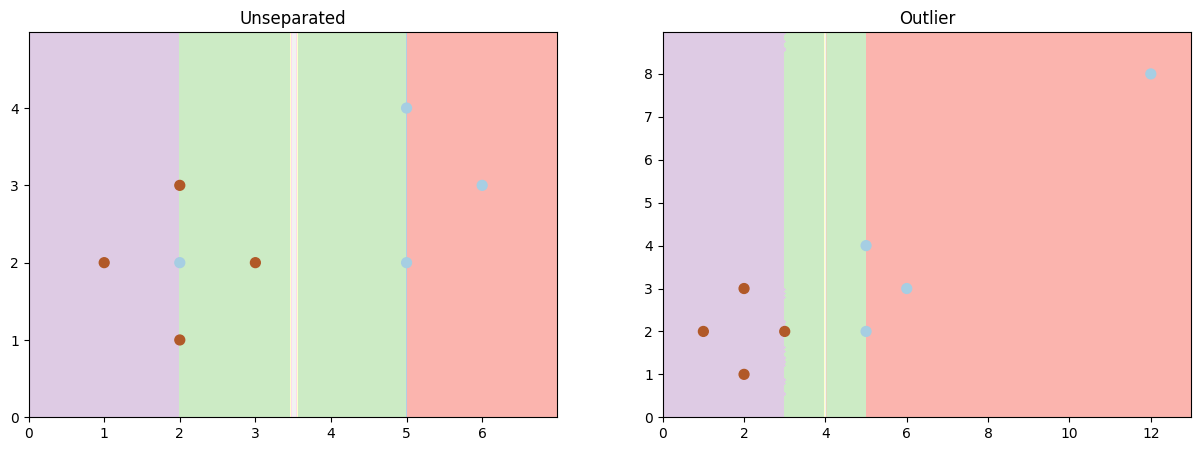

In [7]:
# Your code here...
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

svm_linear_outlier = SVC(C=0.5, kernel='linear').fit(outlier_X, outlier_y)
plot_2d_svc_problem(outlier_X, outlier_y, svm_linear_outlier)
print("Accuracy:", accuracy_score(outlier_y, svm_linear_outlier.predict(outlier_X)))
plt.title("Outlier")
plt.subplot(1, 2, 1)

svm_linear_unsep = SVC(C=0.5, kernel='linear').fit(unsep_X, unsep_y)
plot_2d_svc_problem(unsep_X, unsep_y, svm_linear_unsep)
print("Accuracy:", accuracy_score(unsep_y, svm_linear_unsep.predict(unsep_X)))
plt.title("Unseparated")
plt.subplot(1, 2, 2)

**Q:** How does an outlier affect SVM?  
**Q:** How does a linear SVM handle a linearly inseparable data set?

### 2. Nonlinear SVM

This task will show how the choice of kernel affects the capacity of SVM. On the `unsep` set from the previous task, train three SVM models with different kernel functions: linear, polynomial, and radial basis function (RBF). Vary the hyperparameter $C$ by the values $C\in\{10^{-2},1,10^2\}$. For the other hyperparameters (the degree of the polynomial for the polynomial kernel and the hyperparameter $\gamma$ for the RBF kernel) use the default values. Plot the boundaries between classes (and the margins) on a graph organized in a $3x3$ grid, where the columns represent different kernels and the rows represent different values of the $C$ parameter.

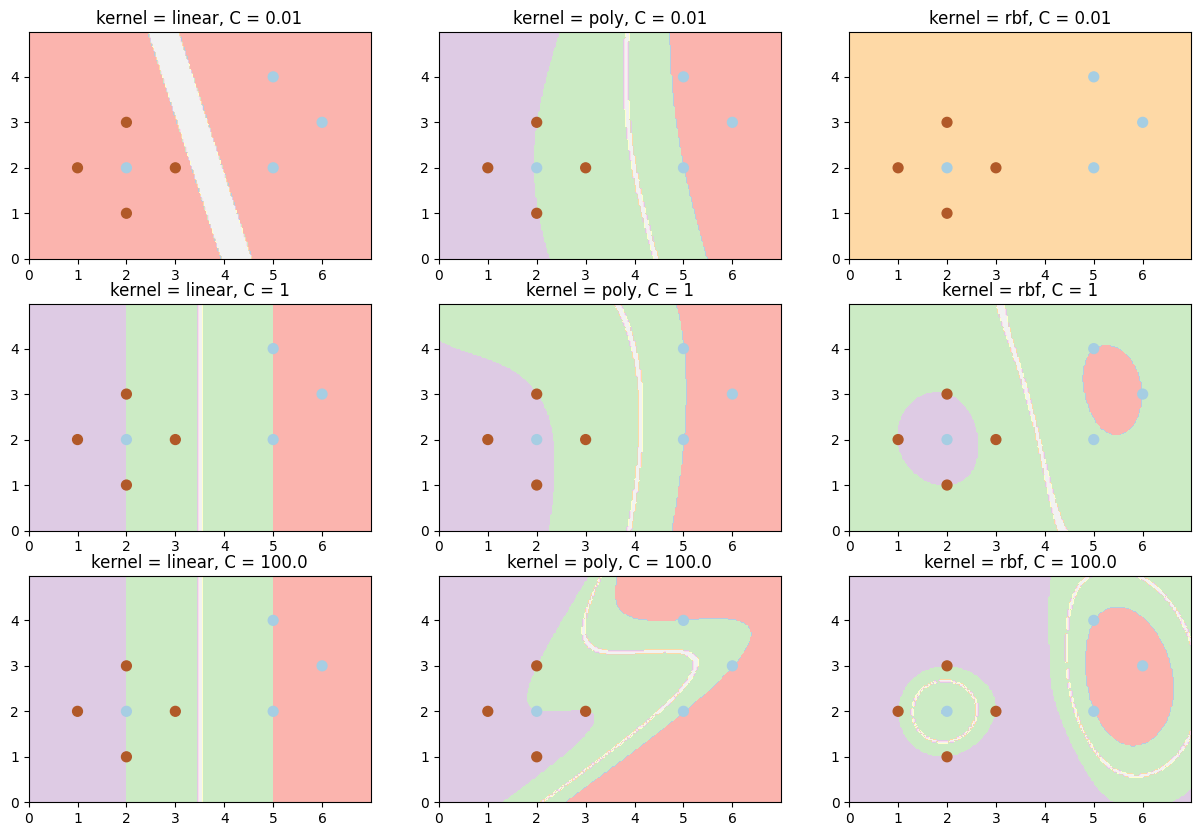

In [8]:
# Your code here...
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
C = [1e-2, 1,1e2]
base_functions = ["linear", "poly", "rbf"]

for i, c in enumerate(C):
    for j, base_function in enumerate(base_functions):
        svm_linear_unsep = SVC(C=c, kernel=base_function).fit(unsep_X, unsep_y)
        
        position = i * len(base_functions) + j + 1
        plt.subplot(3, 3, position)
        plot_2d_svc_problem(unsep_X, unsep_y, svm_linear_unsep)
        plt.title("kernel = {}, C = {}".format(base_function, c))

### 3. Optimization of the SVM's hyperparameters

Together with the hyperparameter $C$, SVM model with the RBF kernel function has an additional hyperparameter $\gamma=\frac{1}{2\sigma^2}$ (precision). This parameter also determines the model's complexity: a large value for $\gamma$ means that the RBF will be narrow, the examples will be mapped into a space where (according to the scalar product) they are very different from each other, which will result in more complex models. Conversely, a small value for $\gamma$ means that the RBF will be wide, the examples will be more similar to each other, resulting in simpler models. This also means that, if we choose a larger $\gamma$, we need to regularize the model more strongly, i.e. we need to choose a smaller $C$, in order to prevent overfitting. For this reason, it is necessary to jointly optimize the hyperparameters $C$ and $\gamma$, which is typically done by an exhaustive grid search. This approach is applied to all the models that contain more than one hyperparameter.

#### (a)

Define a function

> `grid_search(X_train, X_validate, y_train, y_validate, c_range=(c1,c2), g_range=(g1,g2), error_surface=False)`

which optimizes the parameters $C$ and $\gamma$ by grid search. The function should search over the hyperparameters $C\in\{2^{c_1},2^{c_1+1},\dots,2^{c_2}\}$ and $\gamma\in\{2^{g_1},2 ^{g_1+1},\dots,2^{g_2}\}$. The function should return the optimal hyperparameters $(C^*,\gamma^*)$, i.e., those for which the model obtained the smallest error on the validation set. Additionally, if `surface=True`, the function should return matrices (of type `ndarray`) of model errors (expectation of 0-1 loss) on the training set and the validation set. Each matrix is of dimension $(c_2-c_1+1)\times(g_2-g_1+1)$ (rows correspond to different values of $C$ and columns to different values of $\gamma$).

In [9]:
from sklearn.metrics import accuracy_score, zero_one_loss

def grid_search(X_train, X_validate, y_train, y_validate, c_range=(0,5), g_range=(0,5), error_surface=False):
    
    # Your code here...
    best_error, best_c, best_gamma = None, None, None

    if error_surface:
        shape = (c_range[1] - c_range[0] + 1, g_range[1] - g_range[0] + 1)
        train_loss_matrix = np.empty(shape)
        validate_loss_matrix = np.empty(shape)

    for i, c in enumerate(range(c_range[0], c_range[1] + 1)):
        ci = 2 ** c
        for j, g in enumerate(range(g_range[0], g_range[1] + 1)):
            gi = 2 ** g
            model = SVC(C=ci, gamma=gi).fit(X_train, y_train)
            train_predict = model.predict(X_train)
            validate_predict = model.predict(X_validate)
            error = zero_one_loss(y_validate, validate_predict)
            
            if best_error is None or error < best_error:
                best_error, best_c, best_gamma = error, ci, gi
            if error_surface:
                train_loss_matrix[i, j] = zero_one_loss(y_train, train_predict)
                validate_loss_matrix[i, j] = error

    return best_c, best_gamma, train_loss_matrix, validate_loss_matrix #if error_surface else best_c, best_gamma

#### (b)

Using the [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function, generate **two** datasets of $N=200$ examples: one with $n=2$ dimensions and the other with $n=100$ dimensions. Let the examples come from two classes, with two groups corresponding to each class (`n_clusters_per_class=2`), so that the problem is a bit more complex, i.e. more non-linear. Keep all features informative. Divide the set of examples into a training set and a validation set in a 1:1 ratio.

Using the both sets, optimize the SVM with the kernel function RBF, in the grid $C\in\{2^{-5},2^{-4},\dots,2^{15}\}$ and $\gamma\in\{2^{-15},2^{-14},\dots,2^{3}\}$. Plot the error surface of the model on the training set and the validation set, on both data sets (four plots in total) and print the optimal combinations of hyperparameters. You can use the `mlutils.plot_error_surface` function to display the error surface of the model.

C1 = 2, gamma1 = 2
C2 = 16, gamma2 = 0.00048828125


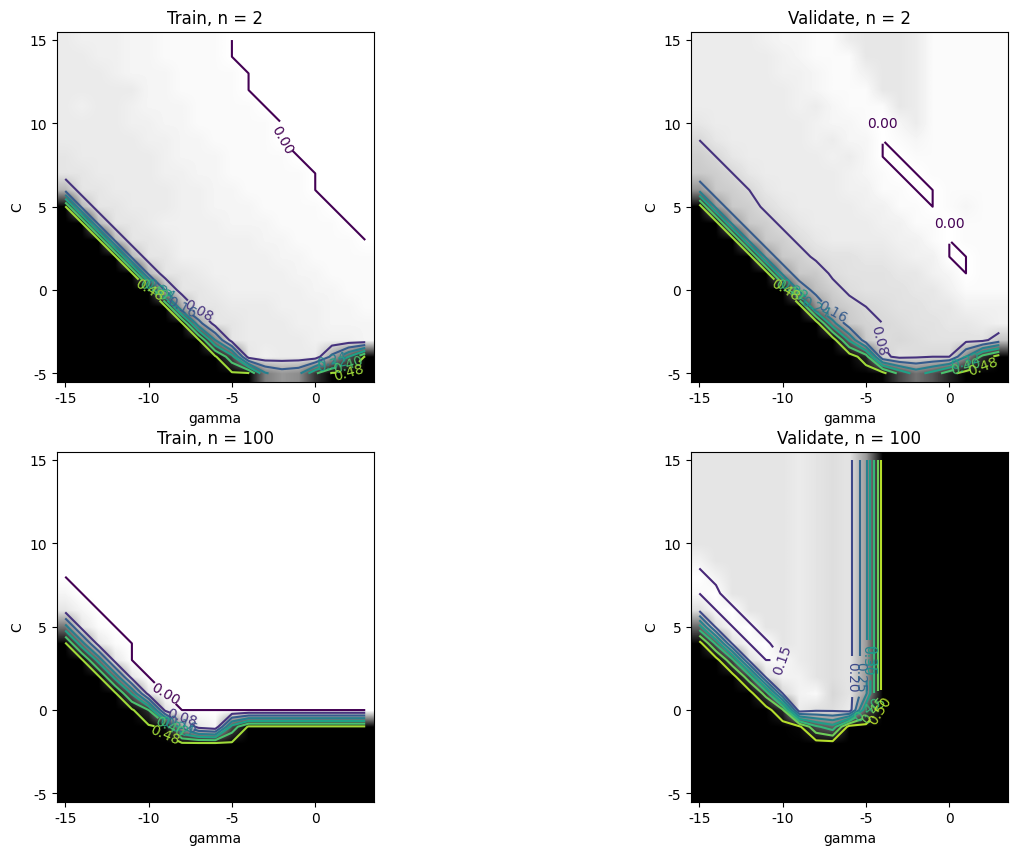

In [10]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Your code here...
X1, y1 = make_classification(n_samples=200,n_features=2,n_redundant=0,n_classes=2,n_clusters_per_class=2)
X2, y2 = make_classification(n_samples=200,n_features=100,n_redundant=0,n_classes=2,n_clusters_per_class=2)
X1_train, X1_validate, y1_train, y1_validate = train_test_split(X1, y1, test_size=0.5)
X2_train, X2_validate, y2_train, y2_validate = train_test_split(X2, y2, test_size=0.5)

c1, g1, tm1, vm1 = grid_search(X1_train, X1_validate, y1_train, y1_validate, (-5,15), (-15,3), True)
c2, g2, tm2, vm2 = grid_search(X2_train, X2_validate, y2_train, y2_validate, (-5,15), (-15,3), True)
print("C1 = {}, gamma1 = {}".format(c1, g1))
print("C2 = {}, gamma2 = {}".format(c2, g2))


fig, axs = plt.subplots(2, 2, figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.title('Train, n = 2')
plot_error_surface(tm1, c_range=(-5,15), g_range=(-15,3))
plt.subplot(2, 2, 2)
plt.title('Validate, n = 2')
plot_error_surface(vm1, c_range=(-5,15), g_range=(-15,3))
plt.subplot(2, 2, 3)
plt.title('Train, n = 100')
plot_error_surface(tm2, c_range=(-5,15), g_range=(-15,3))
plt.subplot(2, 2, 4)
plt.title('Validate, n = 100')
plot_error_surface(vm2, c_range=(-5,15), g_range=(-15,3))

**Q:** Is the error surface different on the training set and the test set? Why?  
**Q:** In the error surface plot, which part of the surface corresponds to overfitting and which part to underfitting? Why?  
**Q:** How does the number of dimensions $n$ affect the error surface, that is, the optimal hyperparameters $(C^*, \gamma^*)$?  
**Q:** It is recommended that an increase in the value of $\gamma$ should be accompanied by a decrease in the value of $C$. Do your results support that recommendation? Explain.
  

### 4. The effect of feature standardization in SVM

From the lab assignment on the topic of regression, we know that the features of different scales can make it impossible to interpret the learned linear regression model. However, this problem occurs with many models, so it is almost always important to scale the features before training, in order to prevent features with larger numerical ranges from dominating those with smaller numerical ranges. This also applies to SVM, where scaling can often significantly improve results. The goal of this task is to experimentally determine the influence of feature scaling on SVM accuracy.

We will now generate a two-class set of $N=500$ examples with $n=2$ features, so that the dimension $x_1$ has a larger values and a larger range than the dimension $x_0$, and we will add one example whose feature value $x_1$ jumps from other examples:

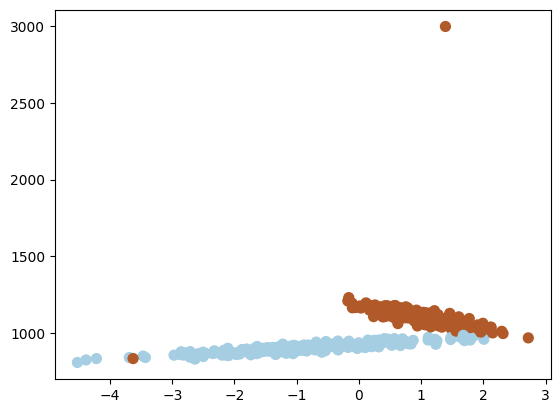

In [11]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500,n_features=2,n_classes=2,n_redundant=0,n_clusters_per_class=1, random_state=69)
X[:,1] = X[:,1]*100+1000
X[0,1] = 3000

plot_2d_svc_problem(X, y)

#### (a)

Familiarize yourself with the histogram plotting function [`hist`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.hist). Display the histograms of the feature values $x_0$ and $x_1$ (use `bins=50` here and in the following tasks).


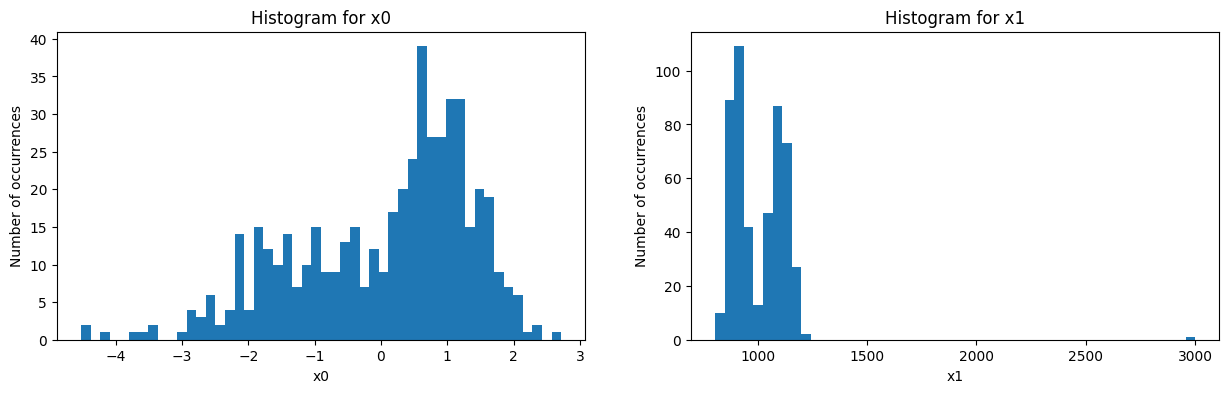

In [12]:
# Your code here...
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.hist(X[:, 0], bins=50)
plt.title("Histogram for x0")
plt.xlabel("x0")
plt.ylabel("Number of occurrences")

plt.subplot(1, 2, 2)
plt.hist(X[:, 1], bins=50)
plt.title("Histogram for x1")
plt.xlabel("x1")
plt.ylabel("Number of occurrences")

plt.show()

#### (b)

Take a look at the [`preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) class. Display histograms of feature values $x_0$ and $x_1$ if they are scaled by min-max scaling (two histograms in total).

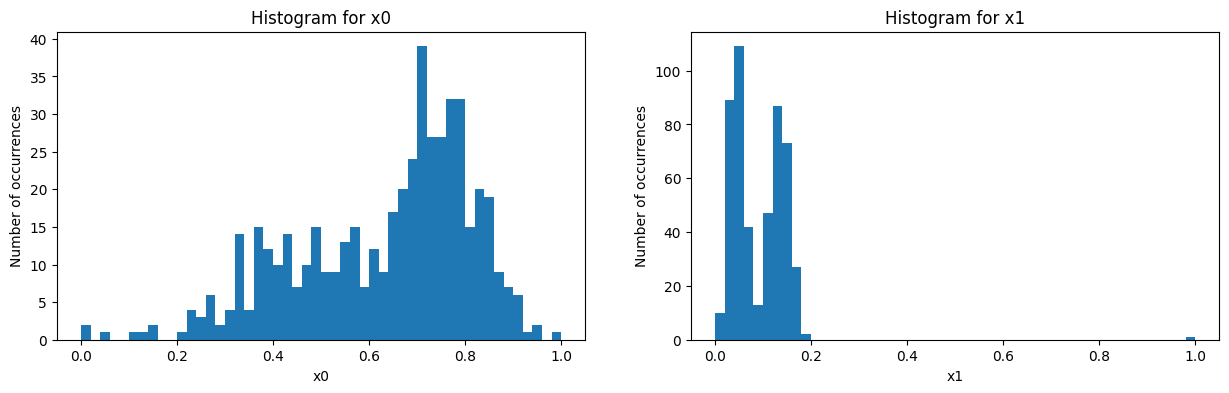

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Your code here...
X_scaled = MinMaxScaler().fit_transform(X)

fig, axs = plt.subplots(1, 2, figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.hist(X_scaled[:, 0], bins=50)
plt.title("Histogram for x0")
plt.xlabel("x0")
plt.ylabel("Number of occurrences")

plt.subplot(1, 2, 2)
plt.hist(X_scaled[:, 1], bins=50)
plt.title("Histogram for x1")
plt.xlabel("x1")
plt.ylabel("Number of occurrences")

plt.show()

**Q:** How does this scaling work? <br>
**Q:** The resulting histograms are very similar. What's the difference? <br>

#### (c)

Take a look at the [`preprocessing.StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class. Display the histograms of the feature values $x_0$ and $x_1$ if they are scaled by standard scaling (two histograms in total).


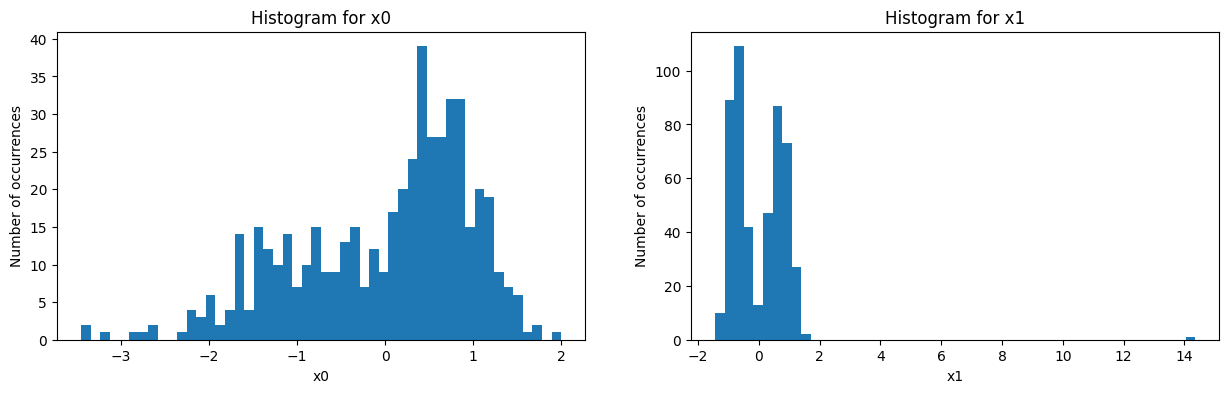

In [16]:
from sklearn.preprocessing import StandardScaler

# Your code here...
X_scaled = StandardScaler().fit_transform(X)

fig, axs = plt.subplots(1, 2, figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.hist(X_scaled[:, 0], bins=50)
plt.title("Histogram for x0")
plt.xlabel("x0")
plt.ylabel("Number of occurrences")

plt.subplot(1, 2, 2)
plt.hist(X_scaled[:, 1], bins=50)
plt.title("Histogram for x1")
plt.xlabel("x1")
plt.ylabel("Number of occurrences")

plt.show()

**Q:** How does this scaling work? <br>
**Q:** The resulting histograms are very similar. What's the difference? <br>

#### (d)

Divide the set of examples into a training set and a test set in a 1:1 ratio. Train the SVM with the RBF kernel function on the training set and calculate the accuracy of the model on the test set, using three variants of the above set: unscaled features, standardized features, and min-max scaling. Use default values for $C$ and $\gamma$. Calculate the accuracy of each of the three models on the training set and the test set. Repeat the procedure several times (e.g. 30) and average the results (in each repetition generate the data as given at the beginning of this task).

**NB:** On the training set, the scaling parameters should first be calculated and then scaling should be applied (function `fit_transform`), while on the test set only scaling should be applied with the parameters obtained on the learning set (function `transform`).

In [17]:
# Your code here...
model = SVC()
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
avg_not_scaled, avg_minmax, avg_standard = [0, 0], [0, 0], [0, 0]

n = 30

for i in range(n):
    X, y = make_classification(n_samples=500,n_features=2,n_classes=2,n_redundant=0,n_clusters_per_class=1)  # dosta ovisi o random state???
    X[:,1] = X[:,1]*100+1000
    X[0,1] = 3000

    X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.5)
    model.fit(X_train, y_train)
    avg_not_scaled[0] += accuracy_score(y_train, model.predict(X_train))
    avg_not_scaled[1] += accuracy_score(y_validate, model.predict(X_validate))

    X_train_minmax = minmax_scaler.fit_transform(X_train)
    X_validate_minmax = minmax_scaler.transform(X_validate)
    model.fit(X_train_minmax, y_train)
    avg_minmax[0] += accuracy_score(y_train, model.predict(X_train_minmax))
    avg_minmax[1] += accuracy_score(y_validate, model.predict(X_validate_minmax))

    X_train_standard = standard_scaler.fit_transform(X_train)
    X_validate_standard = standard_scaler.transform(X_validate)
    model.fit(X_train_standard, y_train)
    avg_standard[0] += accuracy_score(y_train, model.predict(X_train_standard))
    avg_standard[1] += accuracy_score(y_validate, model.predict(X_validate_standard))

for i, j in zip([avg_not_scaled, avg_minmax, avg_standard], ["not-scaled", "minmax", "standard"]):
    print("Model: ", j)
    print("Accuracy on train: ", i[0] / n)
    print("Accuracy on test: ", i[1] / n)

Model:  not-scaled
Accuracy on train:  0.7465333333333333
Accuracy on test:  0.7276
Model:  minmax
Accuracy on train:  0.9486666666666667
Accuracy on test:  0.9331999999999998
Model:  standard
Accuracy on train:  0.9525333333333333
Accuracy on test:  0.9386666666666668


**Q:** Are the results as expected? Explain. <br>
**Q:** Would it be ok if we applied the `fit_transform` function to the entire data set? Why? Would it be ok if we applied the function separately to the training set and separately to the test set? Why?

### 5. k-nearest neighbors algorithm

In this task, we will analyse a simple classification model called **k-nearest neighbor algorithm**. First, you will implement it independently to familiarize yourself with the inner workings of this model, and then you will move on to the analysis of its hyperparameters (using a built-in class, for efficiency).

#### (a)

Implement the `KNN` class, which implements the $k$-nearest neighbors algorithm. An optional parameter of the constructor is the number of neighbors `n_neighbors` ($k$), with the default value set to 3. Define the methods `fit(X, y)` and `predict(X)`, which are used for training the model and prediction, respectively. As a distance measure, use Euclidean distance ([`numpy.linalg.norm`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html); watch out for the `axis` parameter). It is not necessary to implement any weighting function.

In [18]:
from numpy.linalg import norm

class KNN:
    def __init__(self, n_neighbors=3):
        # Your code here...
        self.n_neighbors = n_neighbors
                
    def fit(self, X_train, y_train):
        # Your code here...
        if len(X_train) != len(y_train) or self.n_neighbors > len(X_train):
            raise Exception("Too few data!")
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, X_test):
        # Your code here...
        solution = []
        for xi_test in X_test:
            distances = []
            for i, xi_train in enumerate(self.X_train):
                distances.append((np.linalg.norm(xi_test - xi_train), self.y_train[i]))
            distances.sort()
            classes = {}
            for k in range(self.n_neighbors):
                if distances[k][1] not in classes:
                    classes[distances[k][1]] = 1
                else:
                    classes[distances[k][1]] += 1
            solution.append(max(classes, key=classes.get))
        return np.array(solution)

#### (b)

To make sure your implementation is correct, compare it with the [`neighbors.KNeighborsClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) class. Since the mentioned class uses various optimization tricks when finding the nearest neighbors, make sure to set the `algorithm=brute` parameter, otherwise your predictions may differ. Compare models on a given (artificial) dataset (recall how arrays are compared; [`numpy.all`](https://numpy.org/doc/stable/reference/generated/numpy.all.html)).

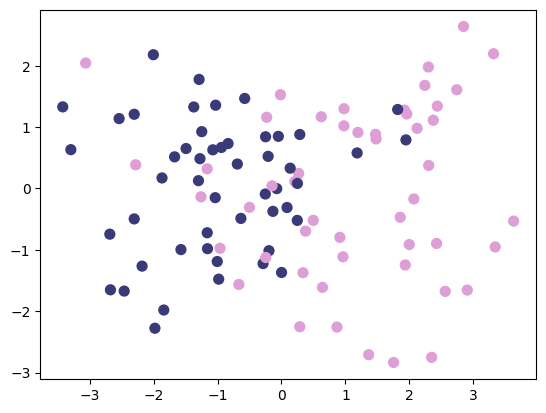

In [19]:
from sklearn.datasets import make_classification
X_art, y_art = make_classification(n_samples=100, n_features=2, n_classes=2, 
                                   n_redundant=0, n_clusters_per_class=2,
                                   random_state=69)
plot_2d_clf_problem(X_art, y_art)

In [20]:
from sklearn.neighbors import KNeighborsClassifier

# Your code here...
my_knn = KNN(5)
my_knn.fit(X_art, y_art)
my_solution = my_knn.predict(X_art)

sklearn_knn = KNeighborsClassifier(algorithm='brute')
sklearn_solution = sklearn_knn.fit(X_art, y_art).predict(X_art)

print(np.all(my_solution == sklearn_solution))

True


### 6. The effect of the hyperparameter *k*

The k-nn algorithm has a hyperparameter $k$ (number of neighbors). This hyperparameter directly affects the complexity of the algorithm, so it is extremely important to choose its value correctly. As with many other algorithms, with the k-nn algorithm the optimal value of the hypermeter $k$ depends on the specific problem, including the number of examples $N$, the number of features (dimensions) $n$ and the number of classes $K$.

In order to obtain more reliable results, it is necessary to repeat some of the experiments on different data sets and then average the obtained error values. Use the function: `knn_eval` which trains and tests the k-nearest neighbors model on a total of `n_instances` of examples. For each value of the hyperparameter from the given interval `k_range` the function repeats `n_trials` measurements, generating for each measurement a new data set and dividing it into a training and a testing set. The test set ratio is defined by the `test_size` parameter. The return value of the function is a quadruple `(ks, best_k, train_errors, test_errors)`. The `best_k` value is the optimal value of the hyperparameter $k$ (the value for which the error on the test set is the smallest). The `train_errors` and `test_errors` values are lists of errors on the training set and the testing set for all considered values of the hyperparameter $k$, while `ks` stores all the considered values of the hyperparameter $k$.

#### (a)

Using the data from the task 5, use the function `plot_2d_clf_problem` to plot the example space and the areas corresponding to the first and second class. Repeat this for $k\in[1, 5, 20, 100]$.

**NB:** The implementation of the `KNeighborsClassifier` algorithm from the `scikit-learn` package will probably work faster than your implementation, so use it in the remaining experiments.

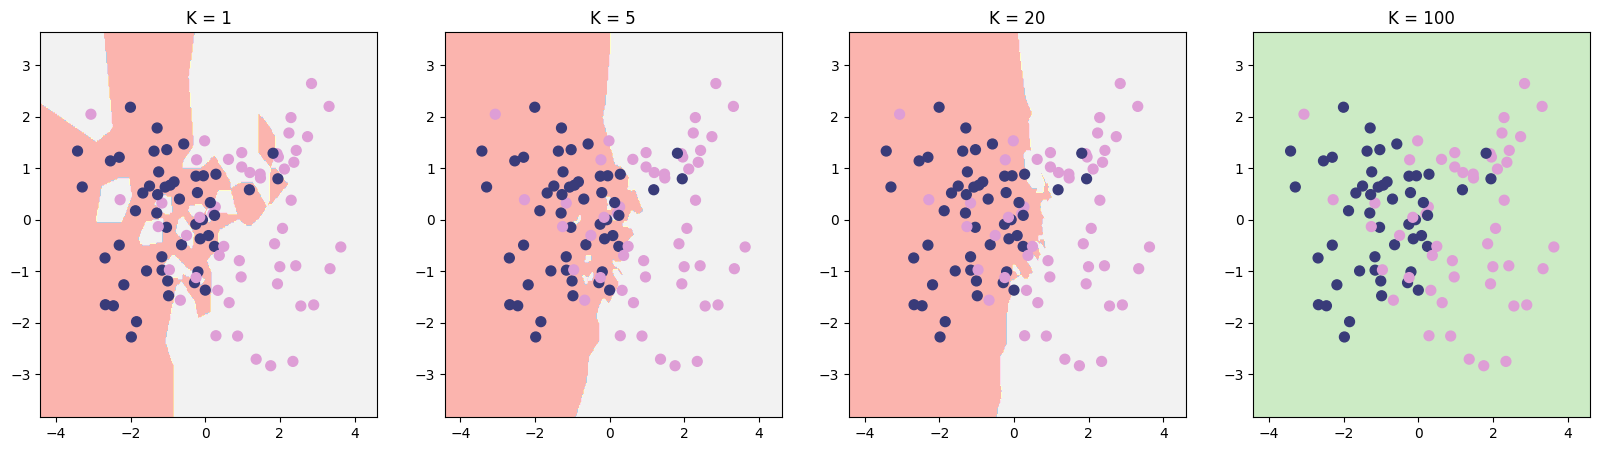

In [21]:
# Your code here...
K = [1, 5, 20, 100]
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, k in enumerate(K):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_art, y_art)
    plt.subplot(1, 4, i + 1)
    plt.title("K = {}".format(k))
    plot_2d_clf_problem(X_art, y_art, knn.predict)

**Q:** How does $k$ affect the border between the classes?  
**Q:** How does the algorithm behave in extreme situations: $k=1$ and $k=100$?

#### (b)

Using the `knn_eval` function, plot the training and testing errors as a function of the hyperparameter $k\in\{1,\dots,20\}$, for $N=\{100, 250, 750\}$ examples. Make 3 separate graphs. For each graph, print the optimal value of the hyperparameter $k$ (easiest as a plot title; see [`plt.title`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.title.html)).

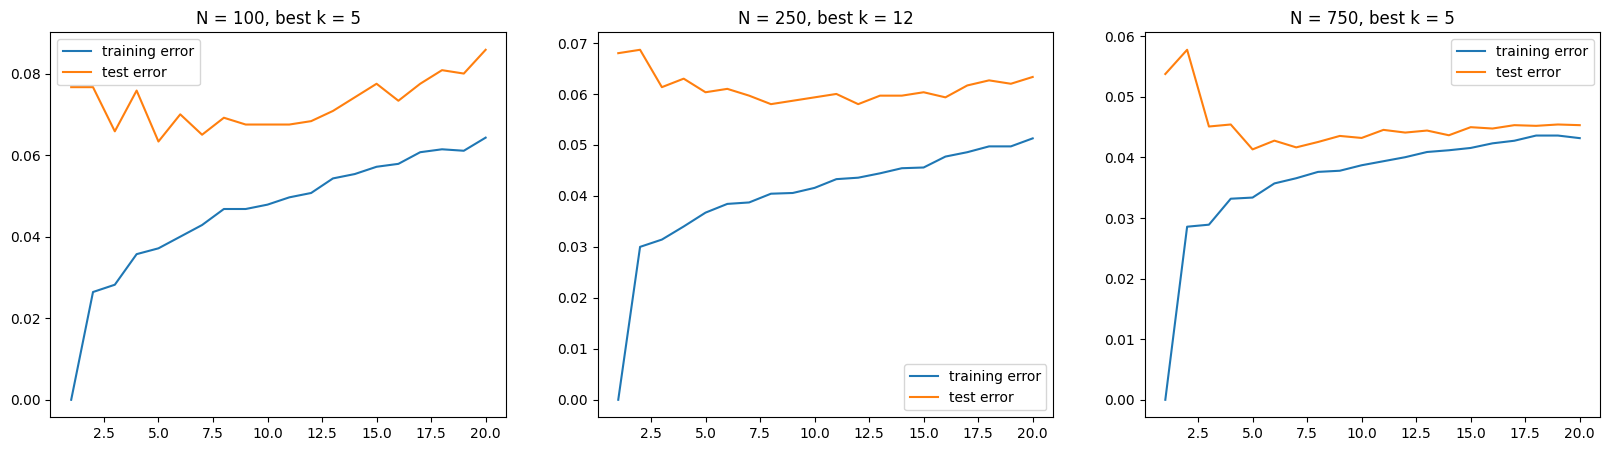

In [22]:
# Your code here...
N = [100, 250, 750]
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, n in enumerate(N):
    ks, best_k, train_errors, test_errors = knn_eval(n_instances=n)
    plt.subplot(1, 3, i + 1)
    plt.title("N = {}, best k = {}".format(n, best_k))
    plt.plot(ks, train_errors, label="training error")
    plt.plot(ks, test_errors, label="test error")
    plt.legend()

**Q:** How does the optimal value of the hyperparameter $k$ change with respect to the number of examples $N$? Why?  
**Q:** Which area of the graph corresponds to overfitting and which to underfitting? Why?  
**Q:** Is it always possible to reach an error of 0 on the training set?

### 7. Irrelevant features

We'd like to check to what extent the k-nearest neighbors algorithm is sensitive to the presence of irrelevant features. In order to do so, we can use the function [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification .html) to generate a set of examples in which some of the features are irrelevant. Namely, the parameter `n_informative` determines the number of essential features, while the parameter `n_features` determines the total number of features. If `n_features > n_informative`, then some of the features will be irrelevant. Instead of using the `make_classification` function directly, we will use the `knn_eval` function, which only takes these parameters but allows us to make more reliable estimates.

Use the `mlutils.knn_eval` function in two ways. In both ways, use $N=1000$ examples, $n=10$ features, and $K=5$ classes, but for the first let all 10 features be informative, and for the second let only 5 out of 10 features be informative. Print the training and testing errors for both models for the optimal value of $k$ (the value for which the testing error is the smallest).

In [23]:
# Your code here...
ks1, best_k1, train_errors1, test_errors1 = knn_eval(n_instances=1000, n_features=10, n_classes=5, n_informative=10)
ks2, best_k2, train_errors2, test_errors2 = knn_eval(n_instances=1000, n_features=10, n_classes=5, n_informative=5)

print("n_informative = 10:")
print("training error =", train_errors1[best_k1 - 1])
print("test error =", test_errors1[best_k1 - 1])
print("best k =", best_k1)
print()
print("n_informative = 5:")
print("training error =", train_errors2[best_k2 - 1])
print("test error =", test_errors2[best_k2 - 1])
print("best k =", best_k2)
print("ks1")

n_informative = 10:
training error = 0.08017857142857143
test error = 0.12800000000000006
best k = 5

n_informative = 5:
training error = 0.16996428571428576
test error = 0.20099999999999998
best k = 13
ks1


**Q:** Is the k-nearest neighbor algorithm sensitive to irrelevant features? Why?  
**Q:** Is this problem present in other models that we have worked with so far (e.g., logistic regression)?  
**Q:** How would a k-nearest neighbor model perform on a dataset with features of different scales? Please explain in detail.

### 8. "Curse of dimensionality"

The "curse of dimensionality" refers to a number of phenomena associated with high-dimensional spaces. In most cases, these phenomena, which are mostly counterintuitive, lead to the decrease of the model's accuracy as the number of dimensions (features) grows.

In general, the increase in the number of dimensions makes all the points in the input space become (in terms of Euclidean distance) increasingly distant from each other and, consequently, the differences in distances between the points are lost. We will experimentally verify that this is indeed the case. Study the function [`metrics.pairwise_distances`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html). Generate 100 random vectors in different dimensions $n\in[1,2,\ldots,50]$ and calculate the *average* Euclidean distance between all the pairs of these vectors. To generate random vectors, use the function [`numpy.random.random`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.random.html). On the same graph, plot the curve for average cosine distances (change the value of the `metric` parameter).

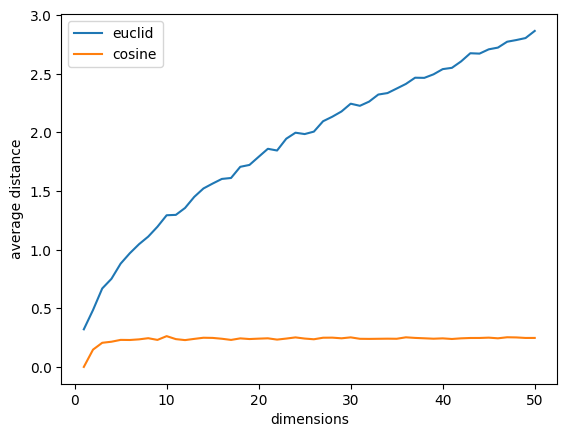

In [25]:
from sklearn.metrics.pairwise import pairwise_distances

# Your code here...
N = 100
dimensions = np.arange(1, 51)
euclidian_dist = np.zeros(50)
cosine_dist = np.zeros(50)
for i, dim in enumerate(dimensions):
    vectors = np.array([np.random.random(dim) for vector in range(N)])
    euclidian_dist[i] = np.mean(pairwise_distances(vectors, metric="euclidean"))
    cosine_dist[i] = np.mean(pairwise_distances(vectors, metric="cosine"))

plt.plot(dimensions, euclidian_dist, label="euclid")
plt.plot(dimensions, cosine_dist, label="cosine")
plt.xlabel("dimensions")
plt.ylabel("average distance")
plt.legend()
plt.show()

**Q:** Try to explain the differences in results. Which of these two measures would you use to classify high-dimensional data?  
**Q:** Why is this problem particularly pronounced with the k-nearest neighbor algorithm?